<img src="Regression_Modelling_Process.jpg">

# Midterm Project

In [1]:
# I will be working on the NYC taxi trip duration data:
# https://www.kaggle.com/c/nyc-taxi-trip-duration/data

# From the data description, in parallel with following the standard regression outlined above,
# I will need to perform the following actions:
#    - Merge test and train datasets, then perform cross-validation on the data as needed
#    - Clean datetime fields
#    - Convert the "store and fwd" variable from a Y/N to a categorical variable
#    - Change trip duration from seconds to a more meaningful value, such as minutes
#    - TIME PERMITTING: Calculate distance by comparing ending lat/long to beginning lat/long.

# A few other things I should do:
#    - Perform basic exploratory analysis, such as info(), head(), tail(), shape, etc.
#    - Groupby vendor id and see which vendors are offering the most rides
#    - Create a histogram of rides by day of week and by month
#    - Create a correlation heatmap
#    - Spin up a few violin charts for the variables which look most interesting

# Note that dropoff_datetime minus pickup_datetime will equal trip_duration, which is the variable
# that we are trying to predict, so I'll just have to figure out how to deal with that or whether
# that will screw up anything.

# Also, I'll over-comment throughout just to show my thought process as I work through the exercise.

In [2]:
# Data fields
# id - a unique identifier for each trip
# vendor_id - a code indicating the provider associated with the trip record
# pickup_datetime - date and time when the meter was engaged
# dropoff_datetime - date and time when the meter was disengaged
# passenger_count - the number of passengers in the vehicle (driver entered value)
# pickup_longitude - the longitude where the meter was engaged
# pickup_latitude - the latitude where the meter was engaged
# dropoff_longitude - the longitude where the meter was disengaged
# dropoff_latitude - the latitude where the meter was disengaged
# store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
# trip_duration - duration of the trip in seconds

# Import data

In [3]:
# Import all the shiz so it's already there as and when I need it...

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Data Analysis

In [5]:
print(len(train))
train.head()

1458644


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
print(len(test))
test.head()

625134


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
train.shape

(1458644, 11)

In [8]:
test.shape

(625134, 9)

In [9]:
# Welp, looks like the test dataset has two fewer columns than the train dataset - both the duration
# column and the dropoff_datetime column (which I would have just used with pickup_datetime to
# calculate duration if it had been in the dataset) are missing. So the test dataset would truly
# be a test. Since this was a Kaggle competition, I think they did this on purpose to see whose
# model best predicts the actual duration of the test dataset. Since I don't have an answer key to
# judge by, I may not be able to test how well I did. But, with 1.5 million rows in the train
# dataset, I should have plenty of kindling to get this fire going...

In [10]:
# Since I'm just using the train.csv data, I'll set that dataset equal to df for easier manipulation.
df = train
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
# Nice - no missing data!

# However, three columns are objects, so I'll have to manipulate them later on:
#    - Pickup_datetime and dropoff_datetime will need to go to a date format, and perhaps I'll have to
#      do some feature engineering to just pull out day of week and month of year so I can make some
#      dope histograms
#    - Store_and_fwd_flag should become a categorical variable

In [12]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


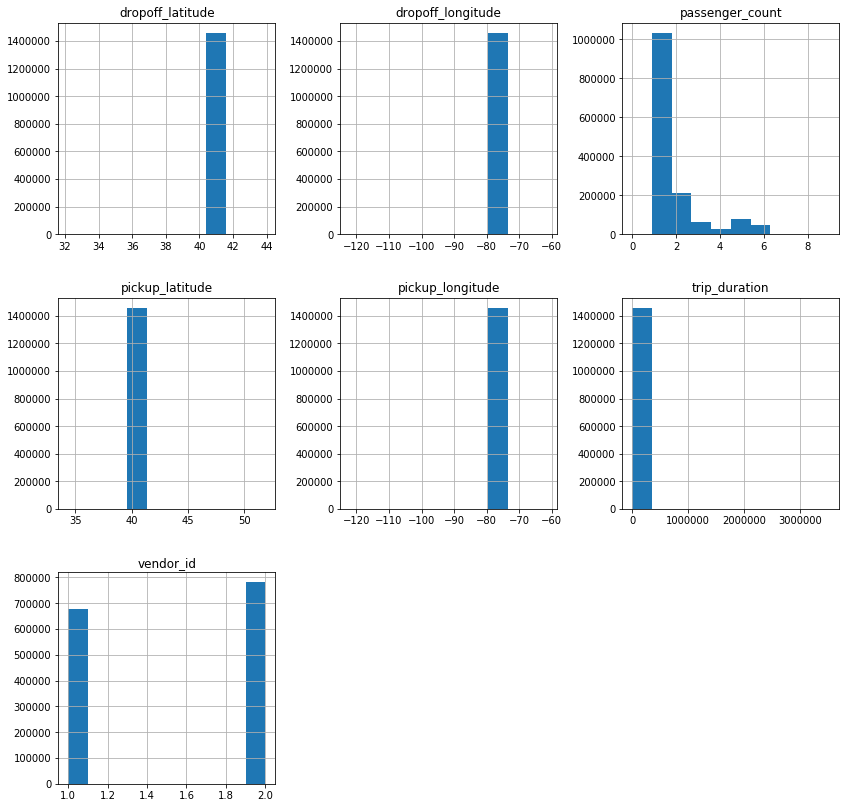

In [13]:
df.hist(figsize=(14, 14))
plt.show()

In [14]:
# The histograms are kinda interesting, but with the nature of the data and default histogram
# scaling, it's tough to notice any variation in latitudes, longitudes, or trip duration. However,
# at least we can see some variation in passenger count, and we can notice that it appears that
# there are only two vendors based on vendor id. I'll do some groupbys to further check into these
# two discrete variables, then will have to circle back to the continuous variables to further
# analyze some other way - probably via correlations and heat maps.

In [15]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [16]:
# Some interesting tidbits:
#    - This view of vendor_id confirms that there are only two vendors in this dataset
#    - Somewhere between 50% and 75% of rides contain one passenger. #urbanloneliness
#    - Who takes a cab ride with 9 people? Is that even legal?
#    - Avg. trip duration is 959 seconds (about 16 mins), which is longer than the median trip
#      duration, which is 662 seconds (about 11 mins). It makes sense that the mean is higher than
#      the median here, since there would be a long tail of longer trips that stretches the mean
#      higher, while lots of shorter trips would keep the median down.

# Long/lat data isn't super meaningful to me yet before doing some feature engineering on it.

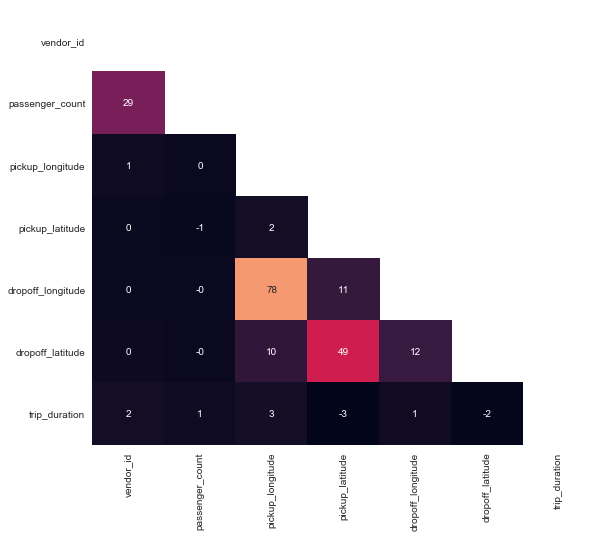

In [17]:
correlations = df.corr()
# change color scheme
sns.set_style('white')
# generate mask for upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot heatmap of correlations
plt.figure(figsize=(9,8))
sns.heatmap(correlations*100, annot=True, fmt='.0f', mask=mask, cbar=False)
plt.show()

In [18]:
# Again, withouot doing some feature engineering, this isn't super meaningful. However, we can
# see that vendor_id happens to be positively correlated with passenger count, so I wonder if
# vendor 2 tends to have larger cabs than vendor 1, or whether it happens to operate in neighborhoods
# which tend to have more group trips rather than single-passenger trips.

# Dropoff/pickup lat/long are each correlated, which makes sense - most cab rides will dropoff
# somewhere near they picked up rather than entirely across the city.

C:\Users\cdagenhart\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


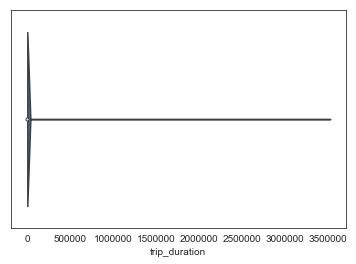

In [19]:
#Violin plots! They are really fun.
sns.violinplot(df.trip_duration)

In [20]:
# Woah. Looks like there's a really long trip. Probably should've looked more closely at df.describe
# to see the max trip_duration **please wait while I scroll up**

# Ok, I'm back - df.describe confirms what this graph is saying: that there is at least one trip that
# lasted 3.5 MILLION seconds (58,000 mins = 972 hours = 40 days). That's way too long. Even if it's
# real, that's definitely gonna skew my regressions, so I'm gonna drop it and probably any other cab
# rides that are too long. Three hours seems like a reasonable threshold but let me just make sure
# I'm not dropping too much data if I do that.

3 * 60 * 60

10800

In [21]:
# Finding which percentile a 3 hour trip would land in. If it's less than 1% of trips, I'll probably
# just drop them so that they don't throw off my regressions.

from scipy import stats
percentile = stats.percentileofscore(df['trip_duration'], 10800)

print(percentile)

99.85520798769268


In [22]:
df = df[df['trip_duration'] < 10800]
len(df)

1456532

In [23]:
# Looks like there were only ~2,000 trips that were dropped for being over 3 hours out of
# ~1.5 million (about 0.15%). So I'm ok dropping those off and modeling just for trips under 3 hours.

# Data cleaning

In [24]:
# Let's see if there are any duplicates...
df = df.drop_duplicates()
df.shape

(1456532, 11)

In [25]:
df = df.dropna()
df.shape

(1456532, 11)

In [26]:
# Looks like there were no duplicates, but now we know...

# Feature engineering

In [27]:
# Converting the datetime fields from objects to date time data types.
df.pickup_datetime = pd.to_datetime(df['pickup_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1456532 non-null object
vendor_id             1456532 non-null int64
pickup_datetime       1456532 non-null datetime64[ns]
dropoff_datetime      1456532 non-null object
passenger_count       1456532 non-null int64
pickup_longitude      1456532 non-null float64
pickup_latitude       1456532 non-null float64
dropoff_longitude     1456532 non-null float64
dropoff_latitude      1456532 non-null float64
store_and_fwd_flag    1456532 non-null object
trip_duration         1456532 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 133.3+ MB


In [28]:
df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,Saturday
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,Friday
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,Saturday
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,Friday
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,Thursday


In [29]:
df.dropoff_datetime = pd.to_datetime(df['dropoff_datetime'])
df['dropoff_day_of_week'] = df['dropoff_datetime'].dt.day_name()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 13 columns):
id                     1456532 non-null object
vendor_id              1456532 non-null int64
pickup_datetime        1456532 non-null datetime64[ns]
dropoff_datetime       1456532 non-null datetime64[ns]
passenger_count        1456532 non-null int64
pickup_longitude       1456532 non-null float64
pickup_latitude        1456532 non-null float64
dropoff_longitude      1456532 non-null float64
dropoff_latitude       1456532 non-null float64
store_and_fwd_flag     1456532 non-null object
trip_duration          1456532 non-null int64
pickup_day_of_week     1456532 non-null object
dropoff_day_of_week    1456532 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 155.6+ MB


In [30]:
# Need to create a dictionary to map the categorical "store_and_fwd_flag" variable to 0 and 1.

store_fwd_dict = {'Y' : 1, 'N' : 0}
df['store_and_fwd_dummy'] = df.store_and_fwd_flag.map(store_fwd_dict)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 14 columns):
id                     1456532 non-null object
vendor_id              1456532 non-null int64
pickup_datetime        1456532 non-null datetime64[ns]
dropoff_datetime       1456532 non-null datetime64[ns]
passenger_count        1456532 non-null int64
pickup_longitude       1456532 non-null float64
pickup_latitude        1456532 non-null float64
dropoff_longitude      1456532 non-null float64
dropoff_latitude       1456532 non-null float64
store_and_fwd_flag     1456532 non-null object
trip_duration          1456532 non-null int64
pickup_day_of_week     1456532 non-null object
dropoff_day_of_week    1456532 non-null object
store_and_fwd_dummy    1456532 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(4)
memory usage: 166.7+ MB


In [31]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_dummy
count,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06
mean,1.534290e+00,1.663939e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.368009e+02,5.523394e-03
std,4.988230e-01,1.313611e+00,7.091146e-02,3.286494e-02,7.067303e-02,3.588766e-02,6.584863e+02,7.411403e-02
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,3.970000e+02,0.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02,0.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03,0.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.073100e+04,1.000000e+00


In [32]:
# Based on the mean, looks like only about 0.5% of trips had to be stored before sending data
# through due to lack of server connections. Seems believable.

# Let's quickly see what store_and_fwd looks like. Will do a  quick test.
df.groupby('store_and_fwd_dummy').mean()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
store_and_fwd_dummy,,,,,,,
0,1.537258,1.666074,-73.973547,40.750948,-73.973463,40.751828,835.445882
1,1.000000,1.279553,-73.963205,40.747290,-73.965613,40.747068,1080.763331


In [33]:
df.groupby('pickup_day_of_week').mean()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_dummy
pickup_day_of_week,,,,,,,,
Friday,1.532526,1.661308,-73.973925,40.751208,-73.973237,40.751823,866.775735,0.005731
Monday,1.533786,1.632991,-73.970361,40.751360,-73.972512,40.752425,809.977667,0.005956
Saturday,1.534585,1.728598,-73.976452,40.749262,-73.974877,40.750299,778.369300,0.004980
Sunday,1.537886,1.716467,-73.973195,40.749009,-73.972246,40.750687,762.609095,0.004886
Thursday,1.532578,1.637574,-73.973634,40.751631,-73.973301,40.752091,896.851266,0.005928
Tuesday,1.536460,1.635340,-73.972604,40.752048,-73.973685,40.752779,854.898917,0.005492
Wednesday,1.532654,1.632619,-73.973688,40.751962,-73.973852,40.752592,879.262484,0.005689


In [34]:
# Dropoff day of week will almost always equal pickup day of week, so I'll just test to make sure
# that these two tables do like very similar (although not quite identical).
df.groupby('dropoff_day_of_week').mean()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_dummy
dropoff_day_of_week,,,,,,,,
Friday,1.532503,1.660728,-73.973928,40.751224,-73.973236,40.751794,865.996000,0.005697
Monday,1.533688,1.633079,-73.970301,40.751359,-73.972533,40.752433,809.619738,0.005938
Saturday,1.534619,1.728166,-73.976381,40.749261,-73.974790,40.750310,779.246073,0.004969
Sunday,1.538050,1.717568,-73.973425,40.748972,-73.972302,40.750639,767.305360,0.004918
Thursday,1.532436,1.637300,-73.973626,40.751663,-73.973325,40.752131,894.619805,0.005996
Tuesday,1.536297,1.634847,-73.972542,40.752052,-73.973663,40.752788,854.910585,0.005487
Wednesday,1.532839,1.632662,-73.973664,40.751968,-73.973877,40.752614,878.409646,0.005666


In [35]:
# Saturday and Sunday have the shortest trips, whereas Thursday trips are the longest. Interesting...

In [36]:
# One other random thought given this is that there seems to be a meaningful difference in trip
# characteristics based on workdays vs. non-workdays (seems obvious, right?). So, if I had more time,
# I would map in holidays and create a holiday dummy variable, especially since Monday, which is
# more frequently a holiday, looks to be in between Sat/Sun and the other weekdays in terms of trip
# duration. But that's too hard, and it's late, so moving on...

In [37]:
# So, that's the "day" portion of datetime. But there are still two more aspects to consider: time of
# day and month.

# Also, since from the quick check above it does seem like pickup date and dropoff date are incredibly
# correlated (as one would hope), I'm only going to do further feature engineering on the pickup side
# of the house to make things easier and to avoid collinearity issues.

In [38]:
# Now for month:
df['pickup_month'] = df['pickup_datetime'].dt.month_name()
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day_of_week,dropoff_day_of_week,store_and_fwd_dummy,pickup_month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,March
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,0,June
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,0,January
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,0,April
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,0,March


In [39]:
# Now for time of day - I'm just gonna round to hours, otherwise it'll get unwieldy:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df.head(8)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day_of_week,dropoff_day_of_week,store_and_fwd_dummy,pickup_month,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,March,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,0,June,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,0,January,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,0,April,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,0,March,13
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,Saturday,Saturday,0,January,22
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,Friday,Friday,0,June,22
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,Saturday,Saturday,0,May,7


In [40]:
df.groupby('pickup_month')['trip_duration'].mean()

pickup_month
April       847.721054
February    789.740304
January     790.356486
June        890.352641
March       817.386927
May         883.332842
Name: trip_duration, dtype: float64

In [41]:
# Now that we have this new feature, looks like we only have data from January - June. Pour one out
# for the second half of the year. Oh well, there's still a ton of data to play with.

In [42]:
df.groupby('pickup_hour')['trip_duration'].mean()

pickup_hour
0     780.312464
1     739.743239
2     701.298112
3     702.156234
4     733.880871
5     712.226636
6     670.949878
7     758.671797
8     834.554666
9     843.551600
10    847.796595
11    875.480708
12    877.384782
13    897.023939
14    947.759643
15    965.486333
16    964.951226
17    931.520888
18    860.391833
19    789.786585
20    768.603578
21    777.093396
22    804.881827
23    812.186753
Name: trip_duration, dtype: float64

Text(0.5,0,'Day of week')

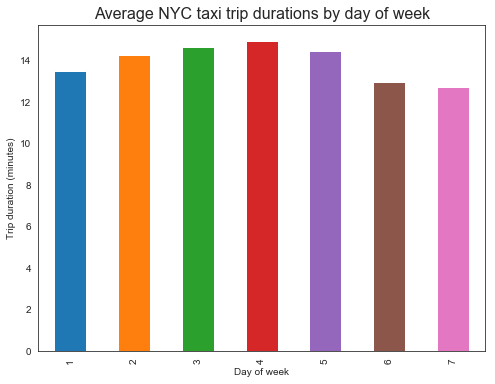

In [43]:
# Cool, so people take longer trips on weekdays, in the summer, and in the afternoons. Now let's
# make some graphs to visualize this!

df['trip_duration_minutes'] = [x / 60 for x in df.trip_duration] # Trip duration will be easier to
# read in minutes rather than seconds as we're graphing.

# ??? How do I get the labels back to weekday strings will still showing weekdays in order?
day_dict = {'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5,
             'Saturday' : 6, 'Sunday' : 7}

day_dict_inv = {v: k for k, v in day_dict.items()}

df['pickup_day_code'] = df.pickup_day_of_week.map(day_dict)

# ??? How do I rotate just x axis labels rather than x ticks?

day_plot_var = df.groupby('pickup_day_code')['trip_duration_minutes'].mean() # Aggregate the data
# day_plot_var = day_plot_var.sort_values()
# day_plot_var['pickup_day_of_week'] = df.pickup_day_code.map(day_dict_inv)
# day_plot_var = day_plot_var.drop(columns=['pickup_day_code']

plt.figure(figsize=(8,6))
day_plot_var.plot(kind='bar')
plt.title('Average NYC taxi trip durations by day of week', fontsize=16) # Add a title
plt.ylabel('Trip duration (minutes)') # Add Y axis Label
plt.xlabel('Day of week') # Add X axis Label

Text(0.5,0,'Hour')

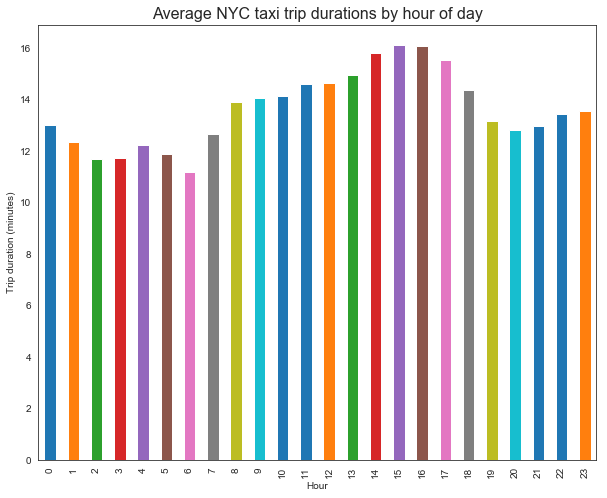

In [44]:
# Graph by hour of day

hour_plot_var = df.groupby('pickup_hour')['trip_duration_minutes'].mean() # Aggregate the data
# hour_plot_var = hour_plot_var.sort_values() # Sort the Aggregation

plt.figure(figsize=(10,8))
hour_plot_var.plot(kind='bar')
plt.title('Average NYC taxi trip durations by hour of day', fontsize=16) # Add a title
plt.ylabel('Trip duration (minutes)') # Add Y axis Label
plt.xlabel('Hour') # Add X axis Label

Text(0.5,0,'Month')

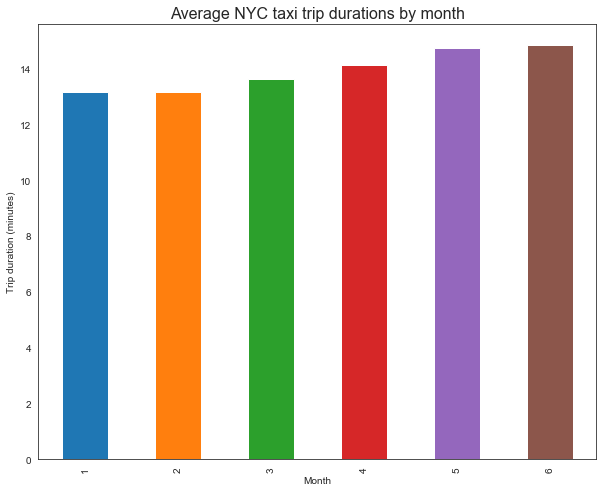

In [45]:
# Graph by month

month_dict = {'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5, 'June' : 6,
              'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11,
              'December' : 12}

df['pickup_month_code'] = df.pickup_month.map(month_dict)

month_plot_var = df.groupby('pickup_month_code')['trip_duration_minutes'].mean() # Aggregate the data
# month_plot_var = month_plot_var.sort_values() # Sort the Aggregation

plt.figure(figsize=(10,8))
month_plot_var.plot(kind='bar')
plt.title('Average NYC taxi trip durations by month', fontsize=16) # Add a title
plt.ylabel('Trip duration (minutes)') # Add Y axis Label
plt.xlabel('Month') # Add X axis Label

In [46]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day_of_week,dropoff_day_of_week,store_and_fwd_dummy,pickup_month,pickup_hour,trip_duration_minutes,pickup_day_code,pickup_month_code
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,March,17,7.583333,1,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,0,June,0,11.050000,7,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,0,January,11,35.400000,2,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,0,April,19,7.150000,3,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,0,March,13,7.250000,6,3


In [47]:
# Now, time to create some dummy variables...
df = pd.get_dummies(df, columns=['pickup_day_of_week', 'pickup_month', 'pickup_hour'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0,0,1,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,0,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,0,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 53 columns):
id                              1456532 non-null object
vendor_id                       1456532 non-null int64
pickup_datetime                 1456532 non-null datetime64[ns]
dropoff_datetime                1456532 non-null datetime64[ns]
passenger_count                 1456532 non-null int64
pickup_longitude                1456532 non-null float64
pickup_latitude                 1456532 non-null float64
dropoff_longitude               1456532 non-null float64
dropoff_latitude                1456532 non-null float64
store_and_fwd_flag              1456532 non-null object
trip_duration                   1456532 non-null int64
dropoff_day_of_week             1456532 non-null object
store_and_fwd_dummy             1456532 non-null int64
trip_duration_minutes           1456532 non-null float64
pickup_day_code                 1456532 non-null int64
pickup_month_code              

# Model Training

In [49]:
# Ok, I've done some basic data exploration, data cleaning, and feature engineering. Now it's time
# to train the models!

# For now, I haven't really done anything with lat / long, so I'm just going to drop it and
# come back to it later if I have time. Honestly, this isn't great, as I would imagine location
# is actually a big driver of trip duration (likely competing with datetime characteristics as
# for the title of biggest driver), but the data are harder to manipulate, so there we are.

y = df.trip_duration_minutes

X = df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
                     'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'store_and_fwd_flag', 'trip_duration', 'dropoff_day_of_week',
                     'trip_duration_minutes', 'pickup_day_code', 'pickup_month_code'])

X.head()

,vendor_id,passenger_count,store_and_fwd_dummy,pickup_day_of_week_Friday,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,...,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23
0,2,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,2,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# This is 40 variables. Is that too many? We'll see. If I need to cut down, I can always group all
# the hour variables into a few groupings, such as early morning, mid-morning, early afternoon, etc.

In [51]:
y.head()

0     7.583333
1    11.050000
2    35.400000
3     7.150000
4     7.250000
Name: trip_duration_minutes, dtype: float64

In [52]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)
print(len(X_train), len(X_test), len(y_train), len(y_test))

1092399 364133 1092399 364133


In [53]:
# Iterate through a few models and print out some summary statistics
models = [LinearRegression(), Lasso(), Ridge()]
names = ['OLS', 'Lasso', 'Ridge']
for model, name in list(zip(models, names)):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format(name))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('\n') 

Model Stats for: OLS
Train R^2: 0.02357560575581852
Test R^2: 0.02378241231409972
Training MSE: 117.54657852553495
Testing MSE: 117.7589792582806


Model Stats for: Lasso
Train R^2: 0.0
Test R^2: -1.2263316087057774e-06
Training MSE: 120.38472125281544
Testing MSE: 120.62794724789191


Model Stats for: Ridge
Train R^2: 0.023576595247148724
Test R^2: 0.023778984100298772
Training MSE: 117.546459405897
Testing MSE: 117.75939279616699




In [54]:
# Looks like OLS and Ridge are both performing almost equally well (which is to say, not really that
# well at all given R^2 = 0.0235), but it's weird that Lasso's train R^2 is 0 and test R^2 is also
# almost 0...will keep probing

In [55]:
# Cross validation - this literally does the same thing again but with a cross validation
# model to test the results. Let's double-check Lasso with LassoCV to start.

model = LassoCV()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test) 
print('Model Stats for: {}'.format('LassoCV'))
print('Train R^2:', model.score(X_train, y_train))
print('Test R^2:', model.score(X_test, y_test))
print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
print('Model details:', model)
print('\n')

Model Stats for: LassoCV
Train R^2: 0.023576206508397313
Test R^2: 0.0237789382144884
Training MSE: 117.54650620410321
Testing MSE: 117.75939833127131
Model details: LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)




In [56]:
model.alpha_

0.0002150610319463348

In [57]:
model = RidgeCV()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test) 
print('Model Stats for: {}'.format('RidgeCV'))
print('Train R^2:', model.score(X_train, y_train))
print('Test R^2:', model.score(X_test, y_test))
print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
print('Model details:', model)
print('\n')

Model Stats for: RidgeCV
Train R^2: 0.023576592046013922
Test R^2: 0.023779002936235694
Training MSE: 117.54645979126471
Testing MSE: 117.75939052402937
Model details: RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)




In [58]:
model.alpha_

10.0

In [59]:
# These R^2 values still seem super low. I may need to do some more feature selection. Let's see:

# Print the coefficients for the model's formula
print('Model feature coefficients:')
weight_dict = dict(zip(X.columns, model.coef_))
for feat, coeff in list(zip(X.columns, model.coef_)):
    print(feat, 'Coefficient weight: {}'.format(round(coeff, 4)))

Model feature coefficients:
vendor_id Coefficient weight: 0.1623
passenger_count Coefficient weight: 0.12
store_and_fwd_dummy Coefficient weight: 4.0486
pickup_day_of_week_Friday Coefficient weight: 0.6127
pickup_day_of_week_Monday Coefficient weight: -0.4697
pickup_day_of_week_Saturday Coefficient weight: -0.922
pickup_day_of_week_Sunday Coefficient weight: -1.2489
pickup_day_of_week_Thursday Coefficient weight: 1.0464
pickup_day_of_week_Tuesday Coefficient weight: 0.2939
pickup_day_of_week_Wednesday Coefficient weight: 0.6877
pickup_month_April Coefficient weight: 0.2311
pickup_month_February Coefficient weight: -0.7779
pickup_month_January Coefficient weight: -0.7876
pickup_month_June Coefficient weight: 0.881
pickup_month_March Coefficient weight: -0.3782
pickup_month_May Coefficient weight: 0.8316
pickup_hour_0 Coefficient weight: -0.4216
pickup_hour_1 Coefficient weight: -0.9313
pickup_hour_2 Coefficient weight: -1.4627
pickup_hour_3 Coefficient weight: -1.4233
pickup_hour_4 Coef

In [60]:
# Before I start to change these features, pretty sure it wouldn't hurt to add back distance. I'll
# make some rudimentary calculations based on the lat/long changes. Hello, Pythagoras.

# Calculating the difference and using a scale factor of 1000 to get some meaningful numbers. Since
# I'll be squaring these values later, it doesn't matter that I'm not applying any absolute value
# functions here.
df['lat_change'] = df['pickup_latitude']*1000 - df['dropoff_latitude']*1000
df['long_change'] = df['pickup_longitude']*1000 - df['dropoff_longitude']*1000

df['lat_change'] = df['lat_change'].astype('int64')
df['long_change'] = df['long_change'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 55 columns):
id                              1456532 non-null object
vendor_id                       1456532 non-null int64
pickup_datetime                 1456532 non-null datetime64[ns]
dropoff_datetime                1456532 non-null datetime64[ns]
passenger_count                 1456532 non-null int64
pickup_longitude                1456532 non-null float64
pickup_latitude                 1456532 non-null float64
dropoff_longitude               1456532 non-null float64
dropoff_latitude                1456532 non-null float64
store_and_fwd_flag              1456532 non-null object
trip_duration                   1456532 non-null int64
dropoff_day_of_week             1456532 non-null object
store_and_fwd_dummy             1456532 non-null int64
trip_duration_minutes           1456532 non-null float64
pickup_day_code                 1456532 non-null int64
pickup_month_code              

In [61]:
df['distance_traveled'] = np.sqrt((df.lat_change)**2 + (df['long_change'])**2)

df.distance_traveled = df.distance_traveled.astype('int64')

In [62]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,lat_change,long_change,distance_traveled
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1,0,0,0,0,0,0,2,-17,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,0,0,0,7,19,20
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,0,0,0,0,0,0,53,26,59
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,0,1,0,0,0,0,13,2,13
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,0,0,0,0,0,0,10,0,10


In [63]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_dummy,trip_duration_minutes,pickup_day_code,...,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,lat_change,long_change,distance_traveled
count,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,...,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06,1.456532e+06
mean,1.534290e+00,1.663939e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.368009e+02,5.523394e-03,1.394668e+01,4.049976e+00,...,5.244306e-02,6.210780e-02,6.192449e-02,5.763759e-02,5.772067e-02,5.516391e-02,4.784722e-02,-8.675278e-01,-4.224899e-02,3.443914e+01
std,4.988230e-01,1.313611e+00,7.091146e-02,3.286494e-02,7.067303e-02,3.588766e-02,6.584863e+02,7.411403e-02,1.097477e+01,1.954028e+00,...,2.229189e-01,2.413513e-01,2.410184e-01,2.330569e-01,2.332146e-01,2.283000e-01,2.134429e-01,3.435949e+01,4.624751e+01,4.586915e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,1.666667e-02,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.354000e+03,-3.643000e+03,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,3.970000e+02,0.000000e+00,6.616667e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.300000e+01,-1.300000e+01,1.200000e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02,0.000000e+00,1.103333e+01,4.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,2.000000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03,0.000000e+00,1.788333e+01,6.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,1.100000e+01,3.700000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.073100e+04,1.000000e+00,1.788500e+02,7.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.113000e+04,7.552000e+03,1.119200e+04


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456532 entries, 0 to 1458643
Data columns (total 56 columns):
id                              1456532 non-null object
vendor_id                       1456532 non-null int64
pickup_datetime                 1456532 non-null datetime64[ns]
dropoff_datetime                1456532 non-null datetime64[ns]
passenger_count                 1456532 non-null int64
pickup_longitude                1456532 non-null float64
pickup_latitude                 1456532 non-null float64
dropoff_longitude               1456532 non-null float64
dropoff_latitude                1456532 non-null float64
store_and_fwd_flag              1456532 non-null object
trip_duration                   1456532 non-null int64
dropoff_day_of_week             1456532 non-null object
store_and_fwd_dummy             1456532 non-null int64
trip_duration_minutes           1456532 non-null float64
pickup_day_code                 1456532 non-null int64
pickup_month_code              

In [65]:
# Ok, distance traveled is in - let's try running those regressions again.

X = df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
                     'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'store_and_fwd_flag', 'trip_duration', 'dropoff_day_of_week',
                     'trip_duration_minutes', 'pickup_day_code', 'pickup_month_code',
                     'lat_change', 'long_change'])

X.head()

,vendor_id,passenger_count,store_and_fwd_dummy,pickup_day_of_week_Friday,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,...,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,distance_traveled
0,2,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,17
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,20
2,2,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,59
3,2,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,13
4,2,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


In [66]:
y.head()

0     7.583333
1    11.050000
2    35.400000
3     7.150000
4     7.250000
Name: trip_duration_minutes, dtype: float64

In [67]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)
print(len(X_train), len(X_test), len(y_train), len(y_test))

1092399 364133 1092399 364133


In [68]:
# Iterate through a few models and print out some summary statistics
models = [LinearRegression(), Lasso(), Ridge()]
names = ['OLS', 'Lasso', 'Ridge']
for model, name in list(zip(models, names)):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format(name))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('\n') 

Model Stats for: OLS
Train R^2: 0.5379057588306804
Test R^2: 0.5424140034628051
Training MSE: 55.62908641569981
Testing MSE: 55.19759176111129


Model Stats for: Lasso
Train R^2: 0.5033295907241111
Test R^2: 0.5077817128380013
Training MSE: 59.791528775199644
Testing MSE: 59.375208764529994


Model Stats for: Ridge
Train R^2: 0.537905769956874
Test R^2: 0.5424139628163882
Training MSE: 55.6290850762761
Testing MSE: 55.19759666419912




In [69]:
# Muuuuuccchhhhhh better! Still not absolutely incredible (R-squared still just above 50), but
# it turns out distance traveled is quite a good predictor of trip duration after all...I 
# shouldn't have been so lazy but should have just figured out how best to work in the lat/long
# coordinates from the beginning...

# Even though I worked in a crude distance metric, there are lots of other publicly available data
# I could go grab and work in to improve the model, such as:
#    - Mapping lat/long to specific neighborhoods or at least boroughs. Midtown Manhattan cab rides
#      probably hit more traffic jams than those in other boroughs
#    - Adding in an airport dropoff variable, as there might be dropoff congestion, extending ride
#      times
#    - Accounting for passage over bridges. Currently, my lat/long doesn't take this into account,
#      but if someone traveled over a bridge, they could have actually traveled a much farther
#      distance than the basic "crow flies" numbers I've calculated

# But this isn't a completely embarrassing result, so I'm gonna just go with it for now.

In [70]:
# Cross validation - this literally does the same thing again but with a cross validation
# model to test the results. Let's double-check Lasso with LassoCV to start.

model = LassoCV()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test) 
print('Model Stats for: {}'.format('LassoCV'))
print('Train R^2:', model.score(X_train, y_train))
print('Test R^2:', model.score(X_test, y_test))
print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
print('Model details:', model)
print('\n')

Model Stats for: LassoCV
Train R^2: 0.5033210672164934
Test R^2: 0.5077572455439545
Training MSE: 59.792554875288296
Testing MSE: 59.378160200366146
Model details: LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)




In [71]:
model.alpha_

1.7778883830752485

In [72]:
# Cross validating on Ridge...

model = RidgeCV()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test) 
print('Model Stats for: {}'.format('RidgeCV'))
print('Train R^2:', model.score(X_train, y_train))
print('Test R^2:', model.score(X_test, y_test))
print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
print('Model details:', model)
print('\n')

Model Stats for: RidgeCV
Train R^2: 0.5379057657342072
Test R^2: 0.5424139976200187
Training MSE: 55.62908558462066
Testing MSE: 55.19759246591376
Model details: RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)




In [73]:
model.alpha_

10.0

In [74]:
# Ridge looks a little better, so let's go with ridge...

In [75]:
# Let's check out the new coefficients.

# Print the coefficients for the model's formula
print('Model feature coefficients:')
weight_dict = dict(zip(X.columns, model.coef_))
for feat, coeff in list(zip(X.columns, model.coef_)):
    print(feat, 'Coefficient weight: {}'.format(round(coeff, 4)))

Model feature coefficients:
vendor_id Coefficient weight: -0.0015
passenger_count Coefficient weight: 0.0729
store_and_fwd_dummy Coefficient weight: 0.9835
pickup_day_of_week_Friday Coefficient weight: 0.7086
pickup_day_of_week_Monday Coefficient weight: -0.7953
pickup_day_of_week_Saturday Coefficient weight: -0.5766
pickup_day_of_week_Sunday Coefficient weight: -1.618
pickup_day_of_week_Thursday Coefficient weight: 1.0482
pickup_day_of_week_Tuesday Coefficient weight: 0.392
pickup_day_of_week_Wednesday Coefficient weight: 0.8411
pickup_month_April Coefficient weight: 0.2363
pickup_month_February Coefficient weight: -0.5719
pickup_month_January Coefficient weight: -0.6639
pickup_month_June Coefficient weight: 0.7206
pickup_month_March Coefficient weight: -0.3688
pickup_month_May Coefficient weight: 0.6477
pickup_hour_0 Coefficient weight: -1.0353
pickup_hour_1 Coefficient weight: -1.4213
pickup_hour_2 Coefficient weight: -1.7938
pickup_hour_3 Coefficient weight: -2.2032
pickup_hour_4 C

In [76]:
len(X_train) == len(y_train)

True

In [77]:
# Polynomial testing - part 1 of 2 (split due to memory constraints)

# Make a pipeline model with polynomial transformation
# Currently with linear regression.
# Could use and LASSO or ridge regression with cross-validation, (included in comments)
# degree_min = 2
# degree_max = 3

# degrees = []
# train_errs = []
# test_errs = []
# for degree in range(degree_min,degree_max+1):
#     model = make_pipeline(PolynomialFeatures(degree, interaction_only=False),
#                           LinearRegression()
#                          )
#     #Could replace Ridge() above with a more complicated cross validation method to improve tuning
#     #using a cross validation method will substantially increase runtime
#     model.fit(X_train,y_train, n_jobs=-1)
#     #Get r^2 values for testing predictions and training predictions
#     test_score = model.score(X_test,y_test)
#     test_errs.append(test_score)
#     
#     train_score = model.score(X_train,y_train)
#     train_errs.append(train_score)
#     
#     degrees.append(degree)

In [78]:
# Polynomial testing - part 2 of 2 (split due to memory constraints)

# Make a pipeline model with polynomial transformation
# Currently with basic ridge.
# Could use and LASSO regression with cross-validation, (included in comments)
# degree_min = 4
# degree_max = 5
# 
# degrees = []
# train_errs = []
# test_errs = []
# for degree in range(degree_min,degree_max+1):
#     model = make_pipeline(PolynomialFeatures(degree, interaction_only=False),
#                           Ridge()
#                          )
#     #Could replace Ridge() above with a more complicated cross validation method to improve tuning
#     #using a cross validation method will substantially increase runtime
#     model.fit(X_train,y_train)
#     #Get r^2 values for testing predictions and training predictions
#     test_score = model.score(X_test,y_test)
#     test_errs.append(test_score)
#     
#     train_score = model.score(X_train,y_train)
#     train_errs.append(train_score)
#     
#     degrees.append(degree)

In [79]:
# So I don't have enough memory to run this, but I would see whether model fit were improving
# with the polynomial features without overfitting by comparing the train errors with the test
# errors via the commented-out plot below.

# At that point, I would feel reasonably comfortable with my model but not with my data / feature
# engineering. If I had more time, the most valuable things I could do would revolve around
# finding better and more elegant ways to use the lat/long data and account for neighborhoods and
# physical bottlenecks by importing public data. Also, I could bring in weather data - I'm sure that
# when it's raining heavily or there's snow / winter weather, trips may take a little longer due to
# poor road conditions.

# Create Plot
# plt.scatter(degrees, train_errs, label='Train R^2')
# plt.scatter(degrees, test_errs, label='Test R^2')
# plt.title('Train and Test Accuracy vs Model Complexity')
# plt.xlabel('Maximum Degree of Polynomial Regression')
# plt.legend()

# Summary 

<function matplotlib.pyplot.show(*args, **kw)>

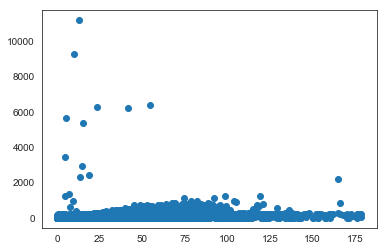

In [80]:
# To finish up, I'll do a few more summary statistics since I've engineered, tweaked, and added
# in the distance variable.


plt.scatter(df.trip_duration_minutes, df.distance_traveled)
plt.show

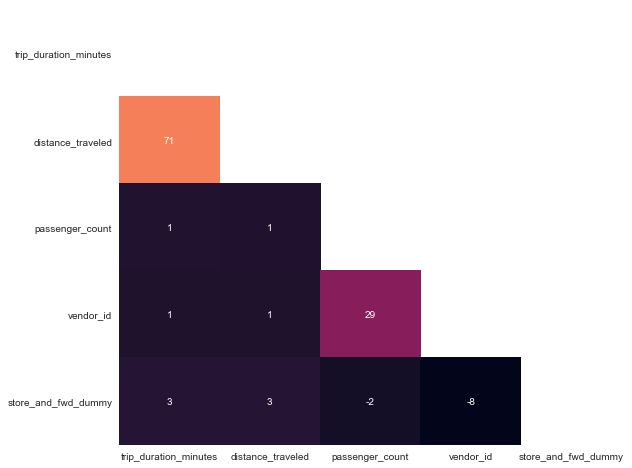

In [81]:
df_corr_subset = df.filter(['trip_duration_minutes', 'distance_traveled', 'passenger_count',
                             'vendor_id', 'store_and_fwd_dummy'], axis=1)

correlations = df_corr_subset.corr()
# change color scheme
sns.set_style('white')
# generate mask for upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot heatmap of correlations
plt.figure(figsize=(9,8))
sns.heatmap(correlations*100, annot=True, fmt='.0f', mask=mask, cbar=False)
plt.show()

In [82]:
# Yep, distance traveled is really important. Other things matter, but that's the area to hone in on
# in more detail for further analysis.